## 1. KITTI 데이터셋 수집과 구축
---
- 다운받은 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋 구축
- 메모리 문제로 배치 사이즈 16 -> 4 권장

In [1]:
# !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip


In [2]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:
        return Compose([
            HorizontalFlip(p=0.5),
            RandomSizedCrop(
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(width=224, height=224)
        ])
    return Compose([
        Resize(width=224, height=224)
    ])

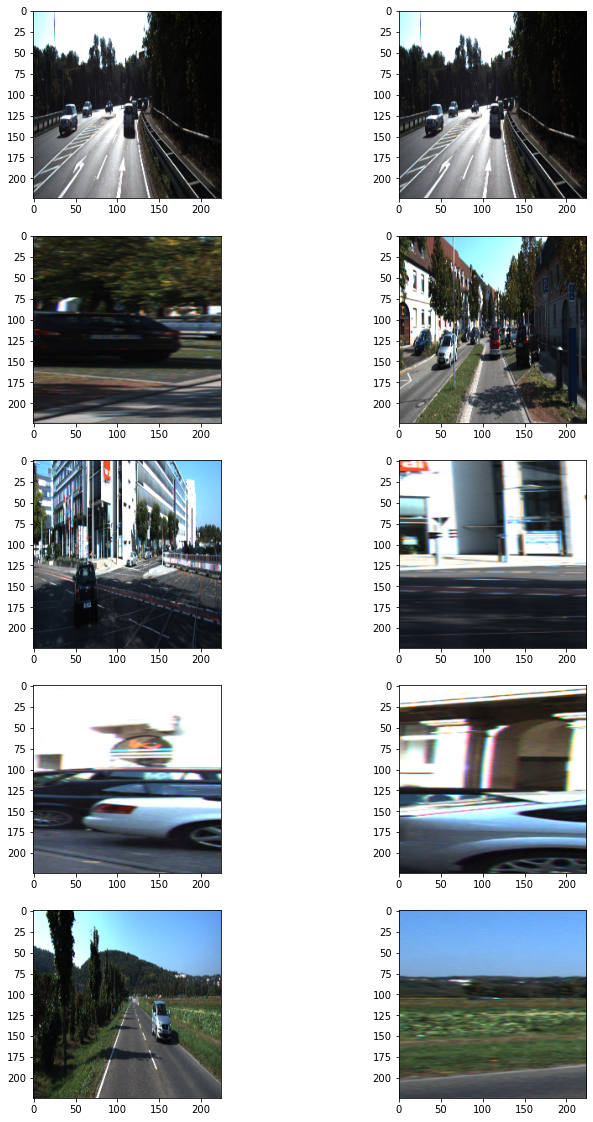

In [4]:
dir_path = os.getenv('HOME') + '/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, 'image_2', '*.png'))

plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image": image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed['image'])

plt.show()

In [5]:
class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self, 
                dir_path,
                batch_size=4,
                img_size=(224, 224, 3),
                output_size=(224, 224),
                is_train=True,
                augmentation=None):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        self. data = self.load_dataset()
        
    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, 'image_2', "*.png"))
        label_images = glob(os.path.join(self.dir_path, 'semantic', '*.png'))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        
        data = [_ for _ in zip(input_images, label_images)]
        
        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)
    
    def __getitem__(self, index):
        batch_data = self.data[
            index*self.batch_size:
            (index + 1)*self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                'image': _input,
                'mask': _output,
            }
        augmented = self.augmentation(**data)
        inputs[i] = augmented['image'] / 255
        outputs[i] = augmented['mask']
        return inputs, outputs
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [6]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(
    dir_path,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path,
    augmentation=test_preproc,
    is_train=False
)

## 2. U-Net++ 모델의 구현
---

### U-Net

In [7]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=conv10)
    return model                          

In [8]:
model = build_model()
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy')
model.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
)

base_path = os.getenv('HOME') + '/project/aiffel/g/g4'

model_path = base_path + '/model/seg_model_unet.h5'
model.save(model_path)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
43/43 [==============================] - 10s 223ms/step - loss: 0.4040 - val_loss: 0.1590
Epoch 2/100
43/43 [==============================] - 9s 220ms/step - loss: 0.1188 - val_loss: 0.1112
Epoch 3/100
43/43 [==============================] - 10s 230ms/step - loss: 0.0914 - val_loss: 0.1180
Epoch 4/100
43/43 [==============================] - 9s 218ms/step - loss: 0.0890 - val_loss: 0.1113
Epoch 5/100
43/43 [==============================] - 9s 219ms/step - loss: 0.0720 - val_loss: 0.0755
Epoch 6/100
43/43 [==============================] - 9s 218ms/step - loss: 0.0649 - val_loss: 0.0901
Epoch 7/100
43/43 [==============================] - 9s 219ms/step - loss: 0.0634 - val_loss: 0.1588
Epoch 8/100
43/43 [==============================] - 9s 220ms/step - loss: 0.0638 - val_loss: 0.1067
Epoch 9/100
43/43 [==============================] - 9s 219ms/step - loss: 0.0566 - val_loss: 0.1144
Epoch 10/100


43/43 [==============================] - 10s 222ms/step - loss: 0.0331 - val_loss: 0.0909
Epoch 77/100
43/43 [==============================] - 9s 218ms/step - loss: 0.0364 - val_loss: 0.1157
Epoch 78/100
43/43 [==============================] - 9s 211ms/step - loss: 0.0337 - val_loss: 0.1110
Epoch 79/100
43/43 [==============================] - 9s 210ms/step - loss: 0.0349 - val_loss: 0.0725
Epoch 80/100
43/43 [==============================] - 9s 209ms/step - loss: 0.0256 - val_loss: 0.0832
Epoch 81/100
43/43 [==============================] - 9s 210ms/step - loss: 0.0387 - val_loss: 0.0681
Epoch 82/100
43/43 [==============================] - 9s 209ms/step - loss: 0.0244 - val_loss: 0.1163
Epoch 83/100
43/43 [==============================] - 9s 209ms/step - loss: 0.0252 - val_loss: 0.0904
Epoch 84/100
43/43 [==============================] - 9s 211ms/step - loss: 0.0325 - val_loss: 0.0662
Epoch 85/100
43/43 [==============================] - 10s 228ms/step - loss: 0.0347 - val_loss

### U-Net +++

In [12]:
def build_model_pp(input_shape=(224, 224, 3)):
    x = Input(input_shape)
    
    x0_0 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='x0_0_conv_1')(x)
    x0_0 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='x0_0_conv_2')(x0_0)
    x0_0_batch = BatchNormalization()(x0_0)
    x0_0_pool = MaxPooling2D(pool_size=(2, 2), name='x_pool')(x0_0_batch)
    
    x1_0 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='x1_0_conv_1')(x0_0_pool)
    x1_0 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='x1_0_conv_2')(x1_0)
    x1_0_batch = BatchNormalization()(x1_0)
    x1_0_pool = MaxPooling2D(pool_size=(2, 2), name='x1_0_pool')(x1_0_batch)
    
    x2_0 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='x2_0_conv_1')(x1_0_pool)
    x2_0 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='x2_0_conv_2')(x2_0)
    x2_0_batch = BatchNormalization()(x2_0)
    x2_0_pool = MaxPooling2D(pool_size=(2, 2), name='x2_0_pool')(x2_0_batch)
    
    x3_0 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='x3_0_conv_1')(x2_0_pool)
    x3_0 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='x3_0_conv_2')(x3_0)
    x3_0_batch = BatchNormalization()(x3_0)
    x3_0_drop = Dropout(0.5)(x3_0_batch)
    x3_0_pool = MaxPooling2D(pool_size=(2, 2), name='x3_0_pool')(x3_0_drop)
    
    x4_0 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='x4_0_conv_1')(x3_0_pool)
    x4_0 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='x4_0_conv_2')(x4_0)
    x4_0_batch = BatchNormalization()(x4_0)
    x4_0_drop = Dropout(0.5)(x4_0_batch)
    
    x3_1_up = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal', name='x3_1_up')(UpSampling2D(size=(2,2))(x4_0_drop))
    x3_1_merge = concatenate([x3_0_batch, x3_1_up], axis=3) #256
    x3_1 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='x3_1_conv_1')(x3_1_merge)
    x3_1 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='x3_1_conv_2')(x3_1)
    
    x2_1 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(x3_0_batch))
    x2_1_merge = concatenate([x2_0_batch, x2_1], axis=3) #128
    
    x2_2_up = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal', name='x2_2_up')(UpSampling2D(size=(2,2))(x3_1))
    x2_2_merge = concatenate([x2_1_merge, x2_2_up], axis=3) # 128
    x2_2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='x2_2_conv_1')(x2_2_merge)
    x2_2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='x2_2_conv_2')(x2_2)
    
    x1_1 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(x2_0_batch))
    x1_1_merge = concatenate([x1_0_batch, x1_1], axis=3) # 64
    
    x1_2 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(x2_1_merge))
    x1_2_merge = concatenate([x1_1_merge, x1_0_batch, x1_2], axis=3)
    
    x1_3_up = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal', name='x1_3_up')(UpSampling2D(size=(2,2))(x2_2))
    x1_3_merge = concatenate([x1_0_batch, x1_1_merge, x1_2_merge, x1_3_up], axis=3)
    x1_3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='x1_3_conv_1')(x1_3_merge)
    x1_3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='x1_3_conv_2')(x1_3)
    
    x0_1 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(x1_0_batch))
    x0_1_merge = concatenate([x0_0_batch, x0_1], axis=3)
    
    x0_2 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(x1_1_merge))
    x0_2_merge = concatenate([x0_0_batch, x0_1_merge, x0_2], axis=3)
    
    x0_3 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(x1_2_merge))
    x0_3_merge = concatenate([x0_0_batch, x0_1_merge, x0_2_merge, x0_3], axis=3)
    
    x0_4_up = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal', name='x0_4_up')(UpSampling2D(size=(2,2))(x1_3))
    x0_4_merge = concatenate([x0_0_batch, x0_1_merge, x0_2_merge, x0_3_merge, x0_4_up], axis=3)
    x0_4 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='x0_4_conv_1')(x0_4_merge)
    x0_4 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='x0_4_conv_2')(x0_4)
    x0_4 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x0_4)
    
    x0_5 = Conv2D(1, 1, activation='sigmoid')(x0_4)
    
    model = Model(inputs=x, outputs=x0_5)
    return model                                                                            
                                                                         

In [13]:
model_pp = build_model_pp()
model_pp.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
x0_0_conv_1 (Conv2D)            (None, 224, 224, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
x0_0_conv_2 (Conv2D)            (None, 224, 224, 32) 9248        x0_0_conv_1[0][0]                
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 224, 224, 32) 128         x0_0_conv_2[0][0]                
_______________________________________________________________________________________

In [14]:
model_pp.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy')
model_pp.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
)
model_path = base_path + '/seg_model_pp.h5'
model_pp.save(model_path)

Epoch 1/100
43/43 [==============================] - 10s 221ms/step - loss: 0.1840 - val_loss: 0.1389
Epoch 2/100
43/43 [==============================] - 9s 211ms/step - loss: 0.0802 - val_loss: 0.1241
Epoch 3/100
43/43 [==============================] - 9s 212ms/step - loss: 0.0733 - val_loss: 0.1505
Epoch 4/100
43/43 [==============================] - 10s 231ms/step - loss: 0.0709 - val_loss: 0.1341
Epoch 5/100
43/43 [==============================] - 10s 225ms/step - loss: 0.0650 - val_loss: 0.1212
Epoch 6/100
43/43 [==============================] - 10s 224ms/step - loss: 0.0656 - val_loss: 0.1029
Epoch 7/100
43/43 [==============================] - 10s 223ms/step - loss: 0.0603 - val_loss: 0.1202
Epoch 8/100
43/43 [==============================] - 9s 221ms/step - loss: 0.0646 - val_loss: 0.1280
Epoch 9/100
43/43 [==============================] - 10s 221ms/step - loss: 0.0621 - val_loss: 0.1259
Epoch 10/100
43/43 [==============================] - 9s 221ms/step - loss: 0.0630 - 

Epoch 79/100
43/43 [==============================] - 9s 214ms/step - loss: 0.0455 - val_loss: 0.1376
Epoch 80/100
43/43 [==============================] - 9s 214ms/step - loss: 0.0354 - val_loss: 0.1302
Epoch 81/100
43/43 [==============================] - 9s 220ms/step - loss: 0.0285 - val_loss: 0.0723
Epoch 82/100
43/43 [==============================] - 9s 220ms/step - loss: 0.0345 - val_loss: 0.0651
Epoch 83/100
43/43 [==============================] - 9s 220ms/step - loss: 0.0276 - val_loss: 0.0794
Epoch 84/100
43/43 [==============================] - 9s 219ms/step - loss: 0.0308 - val_loss: 0.0861
Epoch 85/100
43/43 [==============================] - 9s 217ms/step - loss: 0.0319 - val_loss: 0.1018
Epoch 86/100
43/43 [==============================] - 9s 218ms/step - loss: 0.0311 - val_loss: 0.1183
Epoch 87/100
43/43 [==============================] - 9s 219ms/step - loss: 0.0347 - val_loss: 0.0927
Epoch 88/100
43/43 [==============================] - 9s 218ms/step - loss: 0.0246

## 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
---
- 두 모델의 정량적, 정성적 성능 비교
- 시각화, IoU 계산

In [15]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {'image': origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"] / 255, axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1) # 0.5: 도로인식 결과 범위 threshold
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

In [16]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU: %f' % iou_score)
    return iou_score

In [17]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image": origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"] / 255, axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255
    prediction = output/255
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    
    plt.imshow(output)
    plt.show()
    
    
    if label_path:
        label_img = imread(label_path)
        label_data = {"image": label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1 # 라벨에서 도로로 기재된 영역
        
        return output, prediction, target
    else:
        return output, prediction, _

### U-Net 시각화 및 평가
- model = tf.keras.models.load_model(model_path)

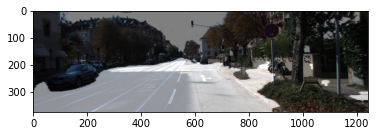

IoU: 0.851811


0.8518111210392467

In [18]:
i = 1
output, prediction, target = get_output(
    model,
    test_preproc,
    image_path = dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path = base_path + f'/result_{str(i).zfill(3)}.png',
    label_path = dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
)

calculate_iou_score(target, prediction)

### U-Net++ 시각화 및 평가

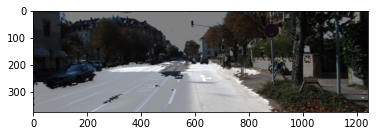

IoU: 0.881474


0.8814738846970918

In [19]:
i = 1
output, prediction, target = get_output(
    model_pp,
    test_preproc,
    image_path = dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path = base_path + f'/result_{str(i).zfill(3)}.png',
    label_path = dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
)

calculate_iou_score(target, prediction)

### Report
- U-Net++ 모델을 나름대로 만들어 학습을 진행한 결과m IoU 스코어에서 아주 미미하지만 성능 개선을 보였다.
- 처음에는 필터를 (1024, 1024) 까지 적용하려 했지만 OOM 문제로 절반씩 낮췄다.